In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
%matplotlib inline
np.random.seed(2)

# Random walk as giving correlations to independent random variables

So a 2D random walk can be generated via picking x, y displacements at random from a symmetric distribution (say, uniform with boundaries $(-\Delta_{max}, \Delta_{max})$) and then summing them up to generate a trajectory.

But this means the summing process introduces correlations into the process...

Start out by generating random variables for displacements in each step:

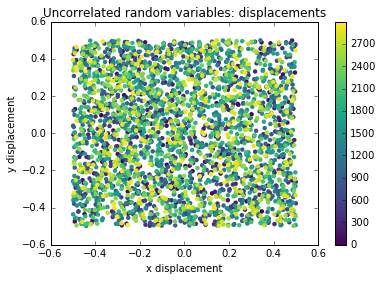

In [2]:
N = 3000
r = np.random.random((N,2)) - 0.5
def plot_2d_scatter(r):
    x, y = r.T
    T = np.arange(N)
    plt.figure()
    plt.xlabel('x displacement')
    plt.ylabel('y displacement')
    plt.title('Uncorrelated random variables: displacements')
    plt.scatter(x,y, c=T, linewidth=0, cmap = 'viridis')
    plt.colorbar()
plot_2d_scatter(r)

And then sum them along the first (time) axis to generate a random walk:

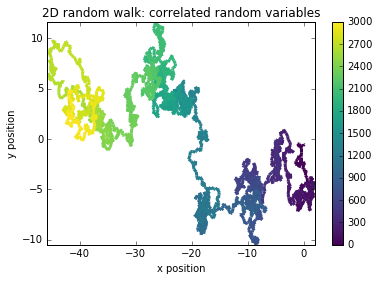

In [3]:
r_history = np.cumsum(r, axis=0)

def plot_2d_line(r_history):
    xh, yh = r_history.T
    max_time = len(xh)
    T = np.arange(0, max_time)

    # a continuously changing colored line plot
    # http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    points = np.array([xh, yh]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap=plt.get_cmap('viridis'),
                        norm=plt.Normalize(0, max_time))
    lc.set_array(T)
    lc.set_linewidth(3)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.add_collection(lc)
    plt.colorbar(mappable=lc)

    ax.set_xlabel('x position')
    ax.set_ylabel('y position')
    ax.set_xlim(xh.min(), xh.max())
    ax.set_ylim(yh.min(), yh.max())
    ax.set_title('2D random walk: correlated random variables')
plot_2d_line(r_history)

But each of those positions in the random walk is a 2-vector. We could calculate the dot product between the positions at two different time steps and we'd get a measure of how much those two vectors overlap.

Given the following two pairs of 2-vectors:
```
[1    0]
[0.8  0.3]
```

```
[1  0]
[0 -1]
```

it is pretty clear that the first two, which point in roughly the same direction, have a relatively large overlap of $1 * 0.8 + 0 * 0.3 = 0.8$, whereas the second pair - pointing in completely perpendicular directions - will have no overlap whatsoever.

However, as time progresses, the vectors begin to grow in length. Each added random displacement is then more and more negligible compared to the overall vector length. That's going to be an issue, so let's normalize our vectors using the Cartesian sum-of-squares norm:
$$r_{n} = \frac{r}{||r||_2}$$

If we now calculate the overlap between **each** vector in time iteration:

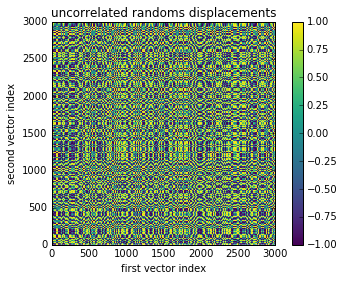

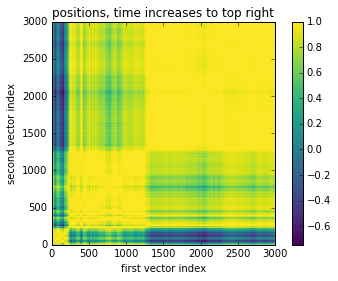

In [4]:
def correlations_matrix(r):
    """
    return correlations (as in, overlaps) between each 2-vector of (1000, 2) matrix
    normalizing the vectors to length 1
    
    here's a sequential code I wrote first
    
    result = np.zeros((len(r), len(r)))
    for i, v1 in enumerate(r):
        for j, v2 in enumerate(r):
            v1_normed = np.sqrt((v1**2).sum())
            v2_normed = np.sqrt((v2**2).sum())
            result[i, j] = v1_normed @ v2_normed
    return result
    
    
    the optimized version turns out to be slightly simpler... compare it yourself!
    """
    
    norm = np.sqrt((r**2).sum(axis=1))
    normed_r = r / norm[:, np.newaxis] #needs to be broadcast as (3000, 2) / (3000, ) fails
    return normed_r @ normed_r.T

def plot(m, title):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    im = ax.imshow(m, origin='lower', interpolation='none', cmap='viridis')
    ax.set_title(title)
    ax.set_xlabel('first vector index')
    ax.set_ylabel('second vector index')
    plt.colorbar(im)
    plt.show()

plot(correlations_matrix(r), 'uncorrelated randoms displacements')
plot(correlations_matrix(r_history), 'positions, time increases to top right')

# The time evolution of a random walk - summing the steps - is a process which introduces correlations between independent random variables!

What about other operations, then? Say we multiply the positions together, if that even makes sense. How would that look like?

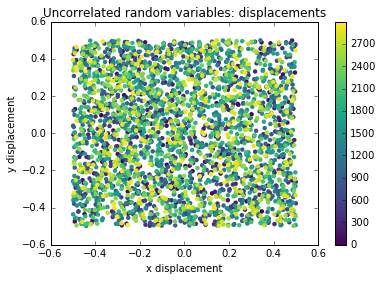

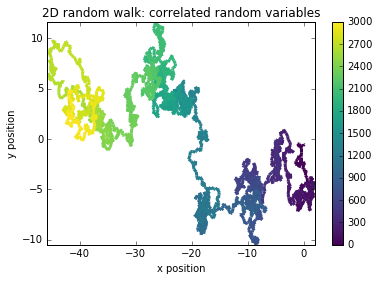

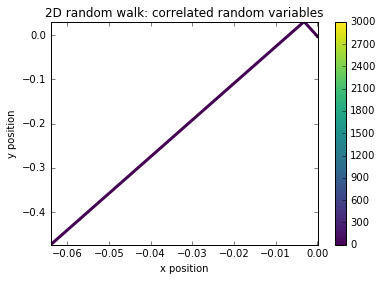

In [5]:
r_product_history = np.cumprod(r, axis=0)
plot_2d_scatter(r)
plot_2d_line(r_history)
plot_2d_line(r_product_history)

Well, that was underwhelming. Then again, since on the $x$ axis we're multiplying $x * x$ with a starting $|x| < 1$... it was to be expected. It pretty much just collapses to $(0, 0)$.

Still, we should plot the correlation matrix anyway:

/home/dominik/.anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/dominik/.anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in true_divide


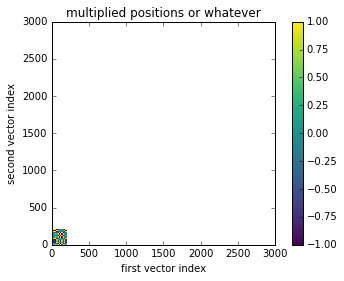

In [6]:
plot(correlations_matrix(r_product_history), "multiplied positions or whatever")

Right! It goes very quickly to 0, and then our normalization messes things up - division by zero introduces NANs. But given that it's all zeroes there, removing our normalization should give us yellow all over the top right side:

/home/dominik/.anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/dominik/.anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in true_divide


<IPython.core.display.Javascript object>


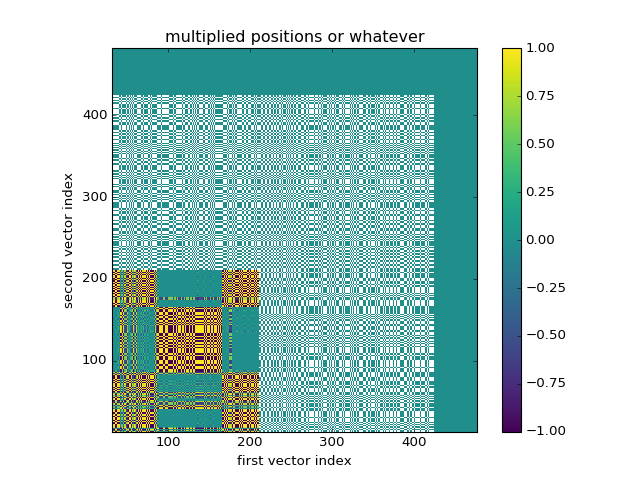

In [7]:
def correlations_matrix_fixed_nan(r):
    """
    return correlations (as in, overlaps) between each 2-vector of (1000, 2) matrix
    normalizing the vectors to length 1
    
    here's a sequential code I wrote first
    
    result = np.zeros((len(r), len(r)))
    for i, v1 in enumerate(r):
        for j, v2 in enumerate(r):
            v1_normed = np.sqrt((v1**2).sum())
            v2_normed = np.sqrt((v2**2).sum())
            result[i, j] = v1_normed @ v2_normed
    return result
    
    
    the optimized version turns out to be slightly simpler... compare it yourself!
    """
    
    norm = np.sqrt((r**2).sum(axis=1))
    normed_r = r / norm[:, np.newaxis] #needs to be broadcast as (3000, 2) / (3000, ) fails
    result = normed_r @ normed_r.T
    result_without_normalization = r @ r.T
    broken_indices = np.isnan(result)
    result[broken_indices] = result_without_normalization[broken_indices]
    return result
%matplotlib notebook
plot(correlations_matrix_fixed_nan(r_product_history), "multiplied positions or whatever")

Well okay, green instead of yellow - you don't quite get ones out of adding zeroes. Still, it's uniform.
Something strange is still happening there...

In [8]:
correlations_matrix_fixed_nan(r_product_history)[150:300, 0]

/home/dominik/.anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in true_divide
/home/dominik/.anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: RuntimeWarning: invalid value encountered in true_divide


array([  9.85609562e-001,  -9.83532195e-001,   9.99612180e-001,
        -9.72744129e-001,  -9.97623336e-001,   9.66993326e-001,
         8.93277005e-001,  -9.92109880e-001,  -9.90595078e-001,
        -9.88541176e-001,   9.86330681e-001,   9.30945917e-001,
        -9.79053459e-001,   9.79013762e-001,  -9.59882104e-001,
         9.72125343e-001,   5.51754395e-002,  -2.12443887e-001,
         1.43449471e-001,  -1.57372327e-001,   1.72267949e-001,
        -2.00600940e-001,  -1.84917450e-001,   2.99806454e-002,
        -2.33917296e-001,   4.99752050e-001,   4.12134140e-001,
         5.31512277e-001,   1.20708829e-001,   1.44705417e-001,
        -1.33580214e-001,  -1.34000053e-001,   1.33507601e-001,
        -1.33973930e-001,   1.33477365e-001,   1.34421277e-001,
         1.34295229e-001,  -1.35017267e-001,   1.34331182e-001,
         1.34581741e-001,  -1.35062776e-001,   1.30390307e-001,
        -1.30947844e-001,  -1.39077866e-001,   1.26930858e-001,
        -1.37135498e-001,  -1.23032342e-

Now infinities are something I didn't quite expect here.